In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
#logger.setLevel(logging.CRITICAL)
#logger.setLevel(logging.ERROR)
#logger.setLevel(logging.WARNING)
logger.setLevel(logging.INFO)
#logger.setLevel(logging.DEBUG)

## 1D

In [3]:
import motion_estimation._1D.polinomial_expansion as PE

In [4]:
pe = PE.Polinomial_Expansion(logger)

In [5]:
def generate_1d_gaussian(size, sigma, mu=0):
    """Generate a 1D Gaussian function sampled in a 1D NumPy array.
    
    Args:
        size (int): The size of the 1D array (size).
        sigma (float): The standard deviation of the Gaussian.
        mu (float): The mean of the Gaussian. Default is 0.
    
    Returns:
        np.ndarray: A 1D array containing the sampled Gaussian function.
    """
    # Create a coordinate grid
    x = np.linspace(-size // 2, size // 2, size)

    # Calculate the 2D Gaussian function
    gaussian_1d = np.exp(-((x - mu)**2) / (2 * sigma**2))

    return gaussian_1d

# Example usage
size = 100  # Define the size of the 2D array
sigma = 10.0  # Define the standard deviation of the Gaussian
line = generate_1d_gaussian(size, sigma)
c = np.ones_like(line)

line = np.arange(40).astype(np.uint8)
#line = np.ones(shape=4, dtype=np.uint8)
print(line)
c = np.ones_like(line)

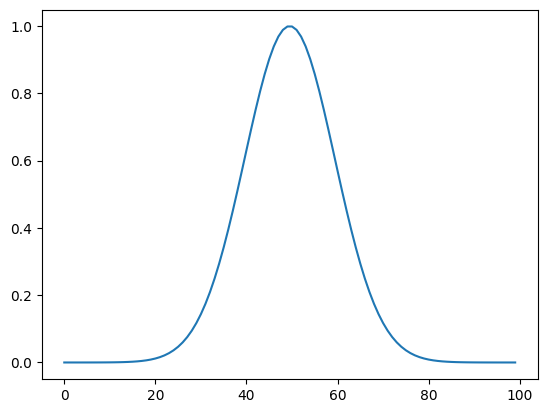

In [6]:
plt.plot(line)

In [7]:
A, B, C = pe.expand(line, c, window_length=9)


Function: expand
self: <motion_estimation._1D.polinomial_expansion.Polinomial_Expansion object at 0x7f6120bd74d0>
f.shape: (100,) 3.726653172078671e-06 0.24815609106104336 0.9987254328882499
c.shape: (100,) 1.0 1.0 1.0
window_length: 9

Function: poly_expand
self: <motion_estimation._1D.polinomial_expansion.Polinomial_Expansion object at 0x7f6120bd74d0>
f.shape: (100,) 3.726653172078671e-06 0.24815609106104336 0.9987254328882499
c.shape: (100,) 1.0 1.0 1.0
sigma: 2.0


ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 100 is different from 3)

In [ ]:
A.shape

In [ ]:
plt.plot(A[:, 0, 0])

In [ ]:
B.shape

In [ ]:
plt.plot(B[:, 0])

In [ ]:
C.shape

In [ ]:
plt.plot(C)

## 2D

In [13]:
def generate_2d_gaussian(size, sigma, mu=0):
    """Generate a 2D Gaussian function sampled in a 2D NumPy array.
    
    Args:
        size (int): The size of the 2D array (size x size).
        sigma (float): The standard deviation of the Gaussian.
        mu (float): The mean of the Gaussian. Default is 0.
    
    Returns:
        np.ndarray: A 2D array containing the sampled Gaussian function.
    """
    # Create a coordinate grid
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Calculate the 2D Gaussian function
    gaussian_2d = np.exp(-((x - mu)**2 + (y - mu)**2) / (2 * sigma**2))

    return gaussian_2d

# Example usage
size = 100  # Define the size of the 2D array
sigma = 10.0  # Define the standard deviation of the Gaussian
img = generate_2d_gaussian(size, sigma)
c = np.ones_like(img)

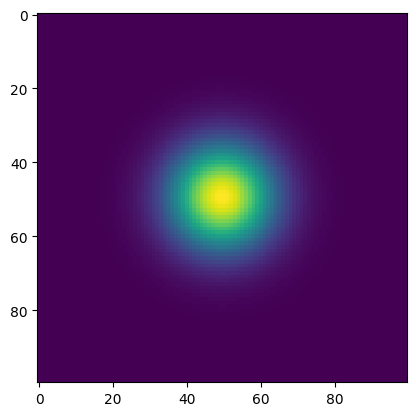

In [14]:
plt.imshow(img)

In [15]:
import motion_estimation._2D.polinomial_expansion as PE

In [16]:
pe = PE.Polinomial_Expansion(logger)

TypeError: Level not an integer or a valid string: <Logger __main__ (INFO)>

#import skimage.io
#img = skimage.io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")
#img = np.random.randint(low=0, high=255, size=(4,3), dtype=np.uint8)
#img = np.ones(shape=(4,3), dtype=np.uint8)
img = np.stack([line, line, line]).T
#img = img[:, 0:3]
print(img)
c = np.ones_like(img)

In [ ]:
img.shape

In [ ]:
A, B, C = pe.expand(img, c, window_side=9)

In [ ]:
A.shape

In [ ]:
plt.imshow(A[:,:, 0, 0])

In [ ]:
plt.imshow(A[:,:, 0, 1])

In [ ]:
plt.imshow(A[:,:, 1, 0])

In [ ]:
plt.imshow(A[:,:, 1, 1])

In [ ]:
B.shape

In [ ]:
plt.imshow(B[:,:, 0])

In [ ]:
plt.imshow(B[:,:, 1])

In [ ]:
C.shape

In [ ]:
plt.imshow(C)

## 3D

In [ ]:
def generate_3d_gaussian(size, sigma, mu=0):
    """Generate a 3D Gaussian function sampled in a 3D NumPy array.
    
    Args:
        size (int): The size of the 3D array (size x size x size).
        sigma (float): The standard deviation of the Gaussian.
        mu (float): The mean of the Gaussian. Default is 0.
    
    Returns:
        np.ndarray: A 3D array containing the sampled Gaussian function.
    """
    # Create a coordinate grid
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    z = np.linspace(-size // 2, size // 2, size)
    x, y, z = np.meshgrid(x, y, z)

    # Calculate the 2D Gaussian function
    gaussian_3d = np.exp(-((x - mu)**2 + (y - mu)**2  + (z - mu)**2) / (2 * sigma**2))

    return gaussian_3d

# Example usage
size = 100  # Define the size of the 2D array
sigma = 10.0  # Define the standard deviation of the Gaussian
vol = generate_3d_gaussian(size, sigma)
c = np.ones_like(vol)

In [ ]:
plt.plot(vol[50, 50, :])

In [ ]:
plt.plot(vol[:, 50, 50])

In [ ]:
plt.plot(vol[50, 50, :])

In [ ]:
import motion_estimation._3D.polinomial_expansion as PE

In [ ]:
pe = PE.Polinomial_Expansion(logger)

In [ ]:
A, B, C = pe.expand(vol, c, window_side=9)

In [ ]:
A.shape

In [ ]:
plt.imshow(A[:,:,50, 0, 0])

In [ ]:
plt.imshow(A[:,:,50, 0, 1])

In [ ]:
plt.imshow(A[:,:,50, 0, 2])

In [ ]:
plt.imshow(A[:,:,50, 1, 0])

In [ ]:
plt.imshow(A[:,:,50, 1, 1])

In [ ]:
plt.imshow(A[:,:,50, 1, 2])

In [ ]:
plt.imshow(A[:,:,50, 2, 0])

In [ ]:
plt.imshow(A[:,:,50, 2, 1])

In [ ]:
plt.imshow(A[:,:,50, 2, 2])

In [ ]:
input()

In [ ]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of sample i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    #print("f", f)
    #print("c", c)
    # Kernel applicability (gaussian)
    n = int(4 * sigma + 1)
    x = np.arange(-n, n + 1, dtype=np.int32)
    a = np.exp(-(x**2) / (2 * sigma**2))

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    #print("b.shape", b.shape)

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [b.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [b.shape[-1]])
    #print("G.shape =", G.shape)
    #print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b) # ab[i] = b[i]*a[i]
    abb = np.einsum("ij,ik->ijk", ab, b) # abb[i,j] = ab[i]*b[j]
    #print("a", a)
    #print("b", b)
    #print("ab", ab)
    #print("abb", abb)
    #print("ab.shape", ab.shape)
    #print("abb.shape", abb.shape)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(b.shape[-1]):
        for j in range(b.shape[-1]):
            #print("G[..., i, j].shape", G[..., i, j].shape)
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )
    '''
    print("b.shape[-1]", b.shape[-1])
    for j in range(b.shape[-1]):
        print("weights", abb[..., j])
        print("c", c)
        print("abb[..., j]", abb[..., j])
        print("G[..., j]", G[..., j])
        G[..., j][0] = scipy.ndimage.correlate1d(
            c, abb[..., j][0], axis=0, mode="constant", cval=0
        )
    v = scipy.ndimage.correlate1d(
        cf, ab, axis=0, mode="constant", cval=0
    )
    '''

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [1, 1])
    A[..., 0, 0] = r[..., 2]

    # Linear term
    B = np.empty(list(f.shape) + [1])
    B[..., 0] = r[..., 1]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    return A, B, C

In [ ]:
A, B, C = poly_exp_1D(line, c, sigma=1.0)

In [ ]:
A

In [ ]:
B

In [ ]:
C

In [ ]:
def flow_iterative_1d(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback

    Parameters
    ----------
    f1
        First signal
    f2
        Second signal
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first signal
    c2
        Certainty of second signal
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis

    Returns
    -------
    d
        Optical flow field. d[i] is the x displacement for sample i
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each sample in the signals
    A1, B1, C1 = poly_exp_1D(f1, c1, sigma)
    A2, B2, C2 = poly_exp_1D(f2, c2, sigma)

    # Sample indexes in the signals
    x = np.arange(f1.shape[0])[:, None].astype(int)
    #print(x)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [1])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(1)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2) # Without effect in 1D

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(int)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0]]) / 2  # Eq. 7.12 (see also Fig. 7.8)
        #print(A1, A2)
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        #print(A.shape, d_[..., None].shape)
        delB = -1 / 2 * (B2[x_[..., 0]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2) # Without effect in 1D
        ATA = S_T @ A_T @ A @ S # G(x) in the thesis (see Fig. 7.8)
        ATb = (S_T @ A_T @ delB[..., None])[..., 0] # h(x) in the thesis (see Fig. 7.8)
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # if mu is not 0, it should be used to regularize the least squares problem
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0))
            h_avg = np.mean(ATb, axis=(0))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            #G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            #h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(1), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

flow_iterative_1d(f1=line, f2=np.roll(line,0), sigma=2.0, c1=c, c2=c, sigma_flow=2.0, num_iter=3, d=None, model="constant", mu=None)

## 2D

In [ ]:
import skimage.io
#img = skimage.io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")
#img = np.random.randint(low=0, high=255, size=(4,3), dtype=np.uint8)
#img = np.ones(shape=(4,3), dtype=np.uint8)
img = np.stack([line, line, line]).T
#img = img[:, 0:3]
print(img)
c = np.ones_like(img)

In [ ]:
def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback
    Uses separable normalized correlation
    $f ~ x^T A x + B^T x + C$
    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    x = np.arange(-n, n + 1, dtype=np.int32)
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]
    #print("a.shape", a.shape)

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack(
        [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
    )
    by = np.stack(
        [np.ones(a.shape), np.ones(a.shape), x, np.ones(a.shape), x**2, x, ], axis=-1,
    )
    #print("bx.shape", bx.shape)
    #print("by.shape", by.shape)

    # Pre-calculate product of certainty and signal
    cf = c * f
    #print("cf.shape", cf.shape)

    # G and v are used to calculate "r" from the paper: v = G*r (see Eq. 4.9 of the thesis)
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])
    #print("G.shape", G.shape)
    #print("v.shape", v.shape)

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper (Eq. 4.6 in the thesis)
    ab = np.einsum("i,ij->ij", a, bx) # ab[i,j] = bx[i,j]*a[i] (multiply each row of "bx" by the corresponding element of "a")
    abb = np.einsum("ij,ik->ijk", ab, bx) # abb[i,j,k] = ab[i,j]*bx[j,k]
    #print("a", a, a.shape)
    #print("bx", bx, bx.shape)
    #print("ab", ab)
    #print("abb", abb)
    #print("ab.shape", ab.shape)
    #print("abb.shape", abb.shape)
    
    # Calculate G and v for each pixel with cross-correlation (axis 0)
    #print("bx.shape[-1]", bx.shape[-1])
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            #print("G[..., i, j].shape", G[..., i, j].shape)
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, by)
    abb = np.einsum("ij,ik->ijk", ab, by)

    # Calculate G and v for each pixel with cross-correlation (axis 1)
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab[..., i], axis=1, mode="constant", cval=0
        )

    # Solve r for each pixel (eq. 4.8 of the thesis)
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    return A, B, C

In [ ]:
A, B, C = poly_exp(img, c, sigma=1.0)

In [ ]:
A

In [ ]:
B

In [ ]:
C

In [ ]:
def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback

    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis

    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(
        np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])),
        axis=-1,
    ).astype(int)
    print(f1.shape)
    print(np.arange(f1.shape[0]))
    print(np.arange(f1.shape[0])[:, None])
    print(np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])))
    print(x)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(int)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        print(A1, A2[x_[..., 0], x_[..., 1]])

        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # if mu is not 0, it should be used to regularize the least squares problem
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

flow_iterative(f1=img, f2=img, sigma=1.0, c1=c, c2=c, sigma_flow=1.0, num_iter=1, d=None, model="constant", mu=None)

## 1D version (ChatGPT)

In [ ]:
def poly_exp_1d(signal, certainty, sigma): # probando
    n = int(4 * sigma + 1)
    x = np.arange(-n, n + 1, dtype=np.int32)
    a = np.exp(-(x**2) / (2 * sigma**2))
    
    # Calculate applicability kernel (1D)
    ab = np.einsum("i,j->ij", a, x)
    abb = np.einsum("ij,ik->ijk", ab, x)
    
    # Pre-calculate product of certainty and signal
    cf = certainty * signal
    
    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty_like(abb)
    v = np.empty_like(ab)
    
    # Apply separable cross-correlations
    for i in range(ab.shape[-1]):
        G[..., i] = scipy.ndimage.correlate1d(certainty, abb[..., i], mode="constant", cval=0)
        v[..., i] = scipy.ndimage.correlate1d(cf, ab[..., i], mode="constant", cval=0)
    
    # Solve r for each pixel (eq. 4.8 of the thesis)
    r = np.linalg.solve(G, v)
    
    # Quadratic term
    A = np.empty((2, 2))
    A[0, 0] = r[3]
    A[0, 1] = r[5] / 2
    A[1, 0] = A[0, 1]
    A[1, 1] = r[4]
    
    # Linear term
    B = np.empty(2)
    B[0] = r[1]
    B[1] = r[2]
    
    # Constant term
    C = r[0]
    
    return A, B, C

def flow_iterative_1d(signal1, signal2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None):
    # Calculate the polynomial expansion at each point in the signals
    A1, B1, C1 = poly_exp_1d(signal1, c1, sigma)
    A2, B2, C2 = poly_exp_1d(signal2, c2, sigma)

    # Initialize displacement field
    if d is None:
        d = np.zeros(2)

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)
    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel
        d_ = d.astype(int)
        
        # Apply separable cross-correlation to calculate linear equation for each pixel
        G = scipy.ndimage.correlate1d(A1 + A2, w, mode="constant", cval=0)
        h = scipy.ndimage.correlate1d(B2 - B1 + (A1 @ d_[..., None])[..., 0], w, mode="constant", cval=0)

        # Solve linear equation for each pixel
        d = np.linalg.solve(G, h)
    
    return d

# Example usage:
signal1 = np.array([1, 2, 3, 4, 5])
signal2 = np.array([2, 3, 4, 5, 6])
certainty1 = np.array([0.9, 0.8, 0.7, 0.6, 0.5])
certainty2 = np.array([0.9, 0.8, 0.7, 0.6, 0.5])

result = flow_iterative_1d(signal1, signal2, sigma=1.0, c1=certainty1, c2=certainty2, sigma_flow=1.0, num_iter=1, d=None, model="constant")